In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.optim import Adam

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

AE: Encoder -> (bottleneck) -> Decoder
- reconstruction loss

Denoising AE: adding noise to the input image
- neural inpainting

VAE: instaed of mapping the input to a fixed vector, we map onto a distribution -> mean vector and stdev vector 

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

path = "./data"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

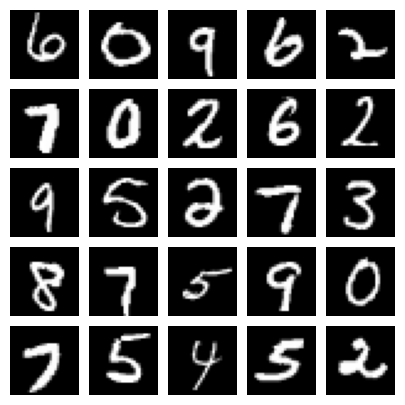

In [3]:
image = next(iter(train_loader))
                
num_examples = 25
sample_images = [image[0][i,0] for i in range(num_examples)]

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig, 111, nrows_ncols=(5,5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")
    
plt.show()

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )
        
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.logvar_layer(x)
        return mean, log_var
    
    def reparameterization(self, mean, var):
        eps = torch.randn_like(var)
        z = mean + var * eps
        return z
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [5]:
model = VAE(input_dim=28*28, hidden_dim=400, latent_dim=200)

In [6]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
import torch.nn.functional as F
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_loss

In [8]:
def train(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, -1)
            
            optimizer.zero_grad()
          
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        batch_loss = round(loss.item() / batch_size, 4)
        running_avg_loss = round(overall_loss / (batch_idx * batch_size), 4)
        print("\tEpoch", epoch, "\tBatch Loss:", batch_loss, "\tAverage Loss: ", running_avg_loss)
        
    return overall_loss

In [9]:
train(model, optimizer, epochs=50)

	Epoch 0 	Batch Loss: 163.2698 	Average Loss:  175.2754
	Epoch 1 	Batch Loss: 159.0521 	Average Loss:  157.4826
	Epoch 2 	Batch Loss: 148.9598 	Average Loss:  152.5771
	Epoch 3 	Batch Loss: 147.0949 	Average Loss:  149.5546
	Epoch 4 	Batch Loss: 152.1085 	Average Loss:  147.2217
	Epoch 5 	Batch Loss: 139.2197 	Average Loss:  145.418
	Epoch 6 	Batch Loss: 144.0622 	Average Loss:  144.1326
	Epoch 7 	Batch Loss: 142.8117 	Average Loss:  142.9693
	Epoch 8 	Batch Loss: 142.4472 	Average Loss:  142.3259
	Epoch 9 	Batch Loss: 143.02 	Average Loss:  141.5498
	Epoch 10 	Batch Loss: 135.9998 	Average Loss:  140.8858
	Epoch 11 	Batch Loss: 136.1086 	Average Loss:  140.3331
	Epoch 12 	Batch Loss: 137.6908 	Average Loss:  139.823
	Epoch 13 	Batch Loss: 140.5267 	Average Loss:  139.4096
	Epoch 14 	Batch Loss: 138.7419 	Average Loss:  139.1532
	Epoch 15 	Batch Loss: 142.0119 	Average Loss:  138.514
	Epoch 16 	Batch Loss: 140.2178 	Average Loss:  138.283
	Epoch 17 	Batch Loss: 134.825 	Average Loss:  

7976102.89453125

In [38]:
# compare original image vs reconstructed image

current_batch = next(iter(train_loader))

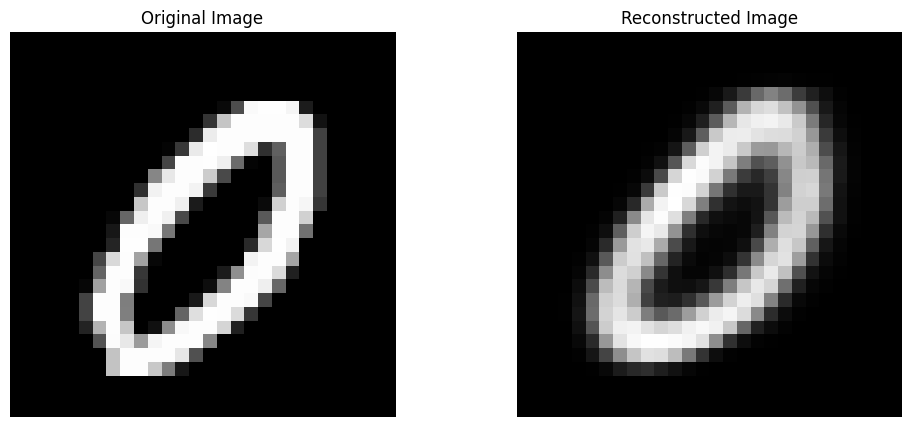

In [58]:
orig_img = current_batch[0][0][0]
reconstructed_img = model(orig_img.reshape(1,-1))[0].detach().numpy().reshape(28,28)

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax1.axis("off"); ax2.axis("off")

ax1.imshow(orig_img, cmap="gray")
ax1.set_title("Original Image")
ax2.imshow(reconstructed_img, cmap="gray")
ax2.set_title("Reconstructed Image");

In [21]:
def generate_digit(mean, var, show=False):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28,28)
    
    if show:
        plt.imshow(digit, cmap="gray")
        plt.axis("off")
        plt.show()
        
    return digit

In [22]:
# generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [23]:
def plot_latent_space(model, scale=1.0, n=25, figsize=15):
    figure = np.zeros((28 * n, 28 * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            digit = generate_digit(xi, yi)
            figure[i*28 : (i+1)*28, j*28: (j+1)*28,] = digit
            
    # plt.figure(figsize=(figsize, figsize))
    # start_range = 14
    # end_range = n * 28 + start_range
    # pixel_range
    
    return figure

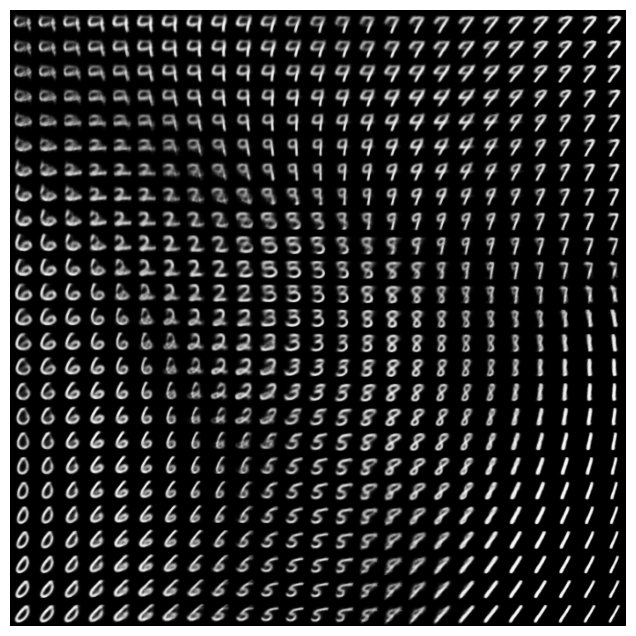

In [36]:
_, ax = plt.subplots(figsize=(8,8))
ax.imshow(plot_latent_space(model), cmap="gray")
ax.axis("off");